# Credit Risk Pricing Strategy Analysis

This notebook analyzes risk-based pricing using the methodology from
"FinTech Lending with LowTech Pricing" paper.

**Key Steps:**
1. Model drift analysis (Validation vs OOT)
2. LGD calculation from actual recoveries
3. Risk-based pricing calculation
4. Temporal adjustment for OOT period

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

predictions_validation = np.load("outputs/predictions.npy")
predictions_oot = np.load("outputs/predictions_test.npy")
data_validation = pd.read_parquet("data/processed/valid.parquet", engine="fastparquet")
data_oot = pd.read_parquet("data/processed/test.parquet", engine="fastparquet")

# Add predictions
data_validation['PD'] = predictions_validation
data_oot['PD'] = predictions_oot

# Fix interest rate format
for df in [data_validation, data_oot]:
    df['int_rate'] = df['int_rate'].astype(str).str.replace('%', '', regex=False).astype(float) / 100

## 1. Model Drift Analysis

Check if model predictions remain calibrated between validation (H1 2018) and OOT (H2 2018).

In [ ]:
# Calculate actual default rates
valid_actual = (data_validation['target'] == 'default').mean()
oot_actual = (data_oot['target'] == 'default').mean()
valid_pred = data_validation['PD'].mean()
oot_pred = data_oot['PD'].mean()

print("="*80)
print("MODEL DRIFT ANALYSIS")
print("="*80)
print(f"\nActual Default Rates:")
print(f"  Validation (H1 2018): {valid_actual:.2%}")
print(f"  OOT (H2 2018):        {oot_actual:.2%}")
print(f"  Drift:                {abs(valid_actual - oot_actual):.2%}")

print(f"\nModel Predictions:")
print(f"  Validation: {valid_pred:.2%}")
print(f"  OOT:        {oot_pred:.2%}")

print(f"\nCalibration Errors:")
print(f"  Validation: {abs(valid_pred - valid_actual):.2%}")
print(f"  OOT:        {abs(oot_pred - oot_actual):.2%}")

# Verdict
drift = abs(oot_actual - valid_actual)
oot_error = abs(oot_pred - oot_actual)

if drift < 0.02 and oot_error < 0.03:
    print("\n✓ DRIFT IS NOT SIGNIFICANT - Model is stable")
elif drift < 0.05 and oot_error < 0.05:
    print("\n⚠ DRIFT IS MODERATE - Consider temporal adjustment")
    adjustment_factor = oot_actual / oot_pred
    print(f"   Suggested adjustment factor: {adjustment_factor:.4f}")
else:
    print("\n✗ DRIFT IS SIGNIFICANT - Model needs attention")

MODEL DRIFT ANALYSIS

Actual Default Rates:
  Validation (H1 2018): 12.05%
  OOT (H2 2018):        8.45%
  Drift:                3.60%

Model Predictions:
  Validation: 12.05%
  OOT:        11.68%

Calibration Errors:
  Validation: 0.00%
  OOT:        3.23%

⚠ DRIFT IS MODERATE - Consider temporal adjustment
   Suggested adjustment factor: 0.7236


## 2. Loss Given Default Calculation

LGD = (Exposure - Total Recoveries) / Exposure

In [ ]:
# Calculate LGD
defaulted = data_validation[data_validation['target'] == 'default'].copy()

total_recovered = (
    defaulted['total_rec_prncp'].fillna(0) + 
    defaulted['total_rec_int'].fillna(0) +
    defaulted['recoveries'].fillna(0) +
    defaulted.get('total_rec_late_fee', 0).fillna(0) -
    defaulted.get('collection_recovery_fee', 0).fillna(0)
)

exposure = defaulted['loan_amnt']
defaulted['LGD'] = ((exposure - total_recovered) / exposure).clip(0, 1)
lgd_portfolio = defaulted['LGD'].mean()

print("="*80)
print("LGD ANALYSIS")
print("="*80)
print(f"Portfolio LGD:         {lgd_portfolio:.2%}")
print(f"Average Recovery Rate: {(1 - lgd_portfolio):.2%}")
print(f"Number of defaults:    {len(defaulted):,}")

# Assign LGD to all loans
data_validation['LGD'] = lgd_portfolio
data_oot['LGD'] = lgd_portfolio

LGD ANALYSIS
Portfolio LGD:         59.65%
Average Recovery Rate: 40.35%
Number of defaults:    27,113



## 3. Risk-Based Pricing Calculation

Required Rate = Risk-free Rate + Expected Loss + Operating Costs + Profit Margin

Expected Loss = PD × LGD

In [ ]:
# Adjust
RISK_FREE_RATE = 0.025    
OPERATING_COSTS = 0.03    
PROFIT_MARGIN = 0.02 

# Calculate for validation set
data_validation['Expected_Loss'] = data_validation['PD'] * data_validation['LGD']
data_validation['Required_Rate'] = (
    RISK_FREE_RATE +
    data_validation['Expected_Loss'] +
    OPERATING_COSTS +
    PROFIT_MARGIN
)
data_validation['Rate_Differential'] = data_validation['int_rate'] - data_validation['Required_Rate']
data_validation['Segment'] = pd.qcut(data_validation['PD'], q=10, labels=range(10), duplicates='drop')

# Scorecard
scorecard = data_validation.groupby('Segment').agg({
    'PD': ['min', 'max', 'mean'],
    'Expected_Loss': 'mean',
    'int_rate': 'mean',
    'Required_Rate': 'mean',
    'Rate_Differential': 'mean',
    'loan_amnt': ['count', 'mean']
}).round(4)

scorecard.columns = ['PD_Min', 'PD_Max', 'PD_Mean', 'Expected_Loss',
                     'Current_Rate', 'Required_Rate', 'Rate_Diff', 'N_Loans', 'Avg_Loan']

print("\n" + "="*100)
print("VALIDATION SET - PRICING SCORECARD")
print("="*100)
print(scorecard.to_string())

print("\n" + "="*100)
print("VALIDATION - PRICING STRATEGY ANALYSIS")
print("="*100)
print(f"Average Rate Differential:  {data_validation['Rate_Differential'].mean():.2%}")
print(f"Loans Overpriced:           {(data_validation['Rate_Differential'] > 0).mean():.1%}")
print(f"Loans Underpriced:          {(data_validation['Rate_Differential'] < 0).mean():.1%}")


VALIDATION SET - PRICING SCORECARD
         PD_Min  PD_Max  PD_Mean  Expected_Loss  Current_Rate  Required_Rate  Rate_Diff  N_Loans    Avg_Loan
Segment                                                                                                     
0        0.0000  0.0412   0.0271         0.0162        0.0770         0.0912    -0.0142    25269  14037.9892
1        0.0423  0.0634   0.0514         0.0306        0.0962         0.1056    -0.0095    22199  14670.9345
2        0.0659  0.0720   0.0693         0.0414        0.1071         0.1164    -0.0093    20393  14934.6675
3        0.0768  0.0891   0.0838         0.0500        0.1162         0.1250    -0.0088    23794  15217.4708
4        0.0907  0.1102   0.1023         0.0610        0.1245         0.1360    -0.0115    25536  15593.6756
5        0.1111  0.1254   0.1207         0.0720        0.1317         0.1470    -0.0154    20523  16052.9443
6        0.1292  0.1536   0.1401         0.0835        0.1376         0.1585    -0.0209    2

/var/folders/rg/wx21mjj55f1bg1byqnwsznm00000gn/T/ipykernel_11669/2138389802.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scorecard = data_validation.groupby('Segment').agg({


## 4. OOT Analysis with Adjustment because default rate dropped

Analize how much default rated changed beteen 2018-Semester1 (validation) and 2018-Semester2 (OOT)

In [ ]:
# Aadjustment factor
adjustment_factor = oot_actual / oot_pred

data_oot['PD_Original'] = data_oot['PD']
data_oot['PD_Adjusted'] = data_oot['PD'] * adjustment_factor

# Calculate pricing with both approaches
data_oot['Expected_Loss_Original'] = data_oot['PD_Original'] * data_oot['LGD']
data_oot['Expected_Loss_Adjusted'] = data_oot['PD_Adjusted'] * data_oot['LGD']

data_oot['Required_Rate_Original'] = (
    RISK_FREE_RATE + data_oot['Expected_Loss_Original'] + OPERATING_COSTS + PROFIT_MARGIN
)
data_oot['Required_Rate_Adjusted'] = (
    RISK_FREE_RATE + data_oot['Expected_Loss_Adjusted'] + OPERATING_COSTS + PROFIT_MARGIN
)

data_oot['Rate_Diff_Original'] = data_oot['int_rate'] - data_oot['Required_Rate_Original']
data_oot['Rate_Diff_Adjusted'] = data_oot['int_rate'] - data_oot['Required_Rate_Adjusted']

print("\n" + "="*100)
print("OOT SET - TEMPORAL ADJUSTMENT")
print("="*100)
print(f"Adjustment Factor: {adjustment_factor:.4f}\n")

print("Before Adjustment:")
print(f"  Avg PD:                {data_oot['PD_Original'].mean():.2%}")
print(f"  Avg Rate Differential: {data_oot['Rate_Diff_Original'].mean():.2%}")
print(f"  Loans Underpriced:     {(data_oot['Rate_Diff_Original'] < 0).mean():.1%}")

print("\nAfter Adjustment (Reflects H2 2018 Reality):")
print(f"  Avg PD:                {data_oot['PD_Adjusted'].mean():.2%}")
print(f"  Avg Rate Differential: {data_oot['Rate_Diff_Adjusted'].mean():.2%}")
print(f"  Loans Overpriced:      {(data_oot['Rate_Diff_Adjusted'] > 0).mean():.1%}")
print(f"  Loans Underpriced:     {(data_oot['Rate_Diff_Adjusted'] < 0).mean():.1%}")


OOT SET - TEMPORAL ADJUSTMENT
Adjustment Factor: 0.7236

Before Adjustment:
  Avg PD:                11.68%
  Avg Rate Differential: -1.59%
  Loans Underpriced:     67.5%

After Adjustment (Reflects H2 2018 Reality):
  Avg PD:                8.45%
  Avg Rate Differential: 0.34%
  Loans Overpriced:      46.1%
  Loans Underpriced:     53.9%


## 5. Visualizations

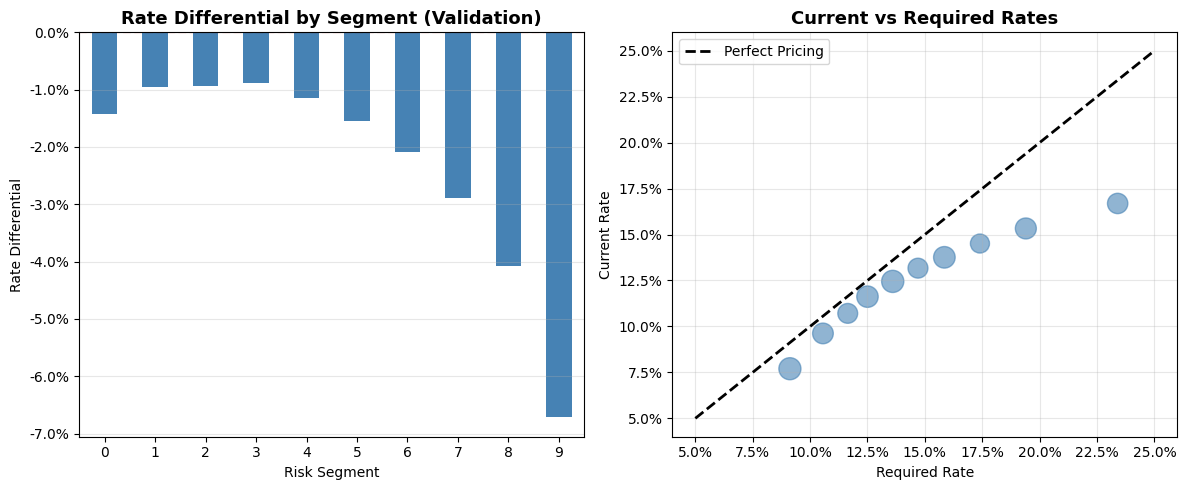

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chart 1: Rate Differential by Segment (Validation)
scorecard['Rate_Diff'].plot(kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title('Rate Differential by Segment (Validation)', fontsize=13, weight='bold')
axes[0].set_xlabel('Risk Segment')
axes[0].set_ylabel('Rate Differential')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
axes[0].set_xticklabels(range(10), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Chart 2: Current vs Required Rate
axes[1].scatter(scorecard['Required_Rate'], scorecard['Current_Rate'],
                  s=scorecard['N_Loans']/100, alpha=0.6, color='steelblue')
axes[1].plot([0.05, 0.25], [0.05, 0.25], 'k--', linewidth=2, label='Perfect Pricing')
axes[1].set_title('Current vs Required Rates', fontsize=13, weight='bold')
axes[1].set_xlabel('Required Rate')
axes[1].set_ylabel('Current Rate')
axes[1].legend()
axes[1].grid(alpha=0.3)
for ax in [axes[1]]:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.tight_layout()
plt.savefig('outputs/pricing_strategy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

1. **Model Performance**: The model is well-calibrated on validation data.
2. **Temporal drift**: Defaulters rated improved from 2018-semester1 to 2018-semester2 (12.05% → 8.45% default rate), requiring temporal adjustment.
3. **Pricing Analysis**:
    - Lendingclub's pricing is below risk-original rates and risk-adjusted rates which indicates a problem of underpricing.
    - It could have a justification, maybe to gain market shat over competitors
4. **Recommendations**:
    - Use the pricing suggesting here for OOT adjusted rates
    - Monitor model PSI to know if it has to be calibrated. For now it is not required.